In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import nltk

import re
from nltk.corpus import stopwords
import seaborn as sns 
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
!jupyter labextension install jupyterlab-plotly-extension
!jupyter labextension enable jupyterlab-plotly-extension
import time
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot trust

Jupyter command `jupyter-labextension` not found.
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Comp

In [2]:
real_News = pd.read_csv("./News _dataset/True.csv")
fake_News = pd.read_csv("./News _dataset/Fake.csv")
real_News['target'] = 1
fake_News['target'] = 0
df = pd.concat([real_News, fake_News]).reset_index(drop = True)
df['complete'] = df['title'] + ' ' + df['text']
df.head()

,title,text,subject,date,target,complete
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,Trump wants Postal Service to charge 'much mor...


In [3]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','says'])
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)
            
    return result

In [4]:
df.subject=df.subject.replace({'politics':'PoliticsNews','politicsNews':'PoliticsNews'})
sub_tf_df=df.groupby('target').apply(lambda x:x['title'].count()).reset_index(name='Counts')
sub_tf_df.target.replace({0:'False',1:'True'},inplace=True)
sub_tf_df


,target,Counts
0,False,23481
1,True,21417


In [5]:
fig = px.bar(sub_tf_df, x="target", y="Counts",
             color='Counts', barmode='group',
             height=400)
fig.show()

In [6]:
sub_check=df.groupby('subject').apply(lambda x:x['title'].count()).reset_index(name='Counts')
fig=px.bar(sub_check,x='subject',y='Counts',color='Counts',title='Count of News Articles by Subject')
fig.show()

In [7]:
df['clean_title'] = df['title'].apply(preprocess)
df['clean_title'][0]

['budget', 'fight', 'looms', 'republicans', 'flip', 'fiscal', 'script']

In [8]:
df['clean_joined_title']=df['clean_title'].apply(lambda x:" ".join(x))
df.head()

,title,text,subject,date,target,complete,clean_title,clean_joined_title
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,PoliticsNews,"December 31, 2017",1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc...",budget fight looms republicans flip fiscal script
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,PoliticsNews,"December 29, 2017",1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond...",military accept transgender recruits monday pe...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,PoliticsNews,"December 31, 2017",1,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, let, mueller, job]",senior republican senator let mueller job
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,PoliticsNews,"December 30, 2017",1,FBI Russia probe helped by Australian diplomat...,"[fbi, russia, probe, helped, australian, diplo...",fbi russia probe helped australian diplomat ti...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,PoliticsNews,"December 29, 2017",1,Trump wants Postal Service to charge 'much mor...,"[trump, wants, postal, service, charge, amazon...",trump wants postal service charge amazon shipm...


In [9]:
# plt.figure(figsize = (20,20)) 
# wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 1].clean_joined_title))
# plt.imshow(wc, interpolation = 'bilinear')

In [10]:
# maxlen = -1
# for doc in df.clean_joined_title:
#     tokens = nltk.word_tokenize(doc)
#     if(maxlen<len(tokens)):
#         maxlen = len(tokens)
# print("The maximum number of words in a title is =", maxlen)
# fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined_title], nbins = 50)
# fig.show()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df.clean_joined_title, df.target, test_size = 0.2,random_state=2, stratify = df.target)
print(X_test.head())
print(y_test.head())

19775       ambassador haley exhausted options north korea
12085           car bomber attacks nato convoy afghanistan
27616    breaking doj seek death penalty charleston chu...
39959    alarming nsa refuses release clinton lynch tar...
38516    shocking picture refugees fighting police offi...
Name: clean_joined_title, dtype: object
19775    1
12085    1
27616    0
39959    0
38516    0
Name: target, dtype: int64


In [12]:
lengths = [len(x) for x in df.clean_joined_title]
max_length = max(lengths)
max_length
trunc_type = 'post'
padding_type = 'post'

In [13]:
embedding_dim = 100
oov_tok = "<OOV>"

tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
vocab_size=len(word_index)
sequences = tokenizer.texts_to_sequences(X_train)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_sequences = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(X_train[0], y_train[0])

budget fight looms republicans flip fiscal script 1


In [14]:
from keras.callbacks import EarlyStopping
overfitCallback = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=0, mode='auto')

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 15, input_length=max_length),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()
num_epochs = 50
history = model.fit(padded, y_train, epochs=num_epochs, validation_data=(test_sequences, y_test), verbose=2, callbacks=[overfitCallback])

print("Training Complete")




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 239, 15)           279975    
                                                                 
 dropout (Dropout)           (None, 239, 15)           0         
                                                                 
 conv1d (Conv1D)             (None, 235, 64)           4864      
                                                                 
 max_pooling1d (MaxPooling1  (None, 58, 64)            0         
 D)                                                              
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 1)               

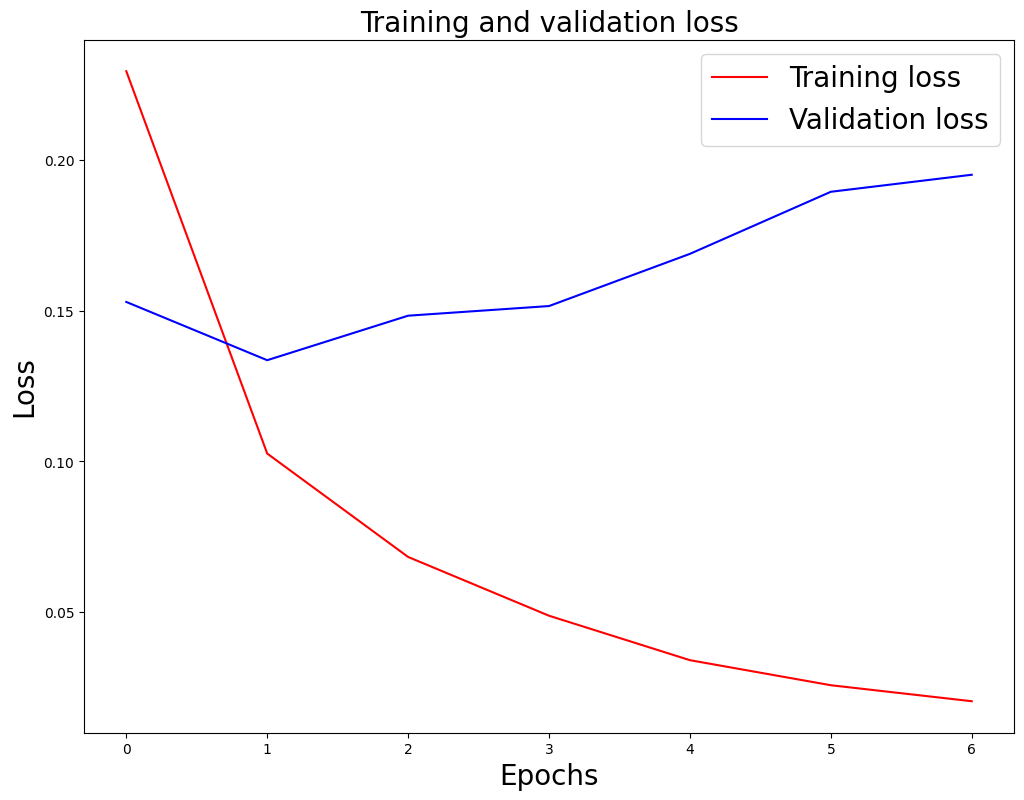

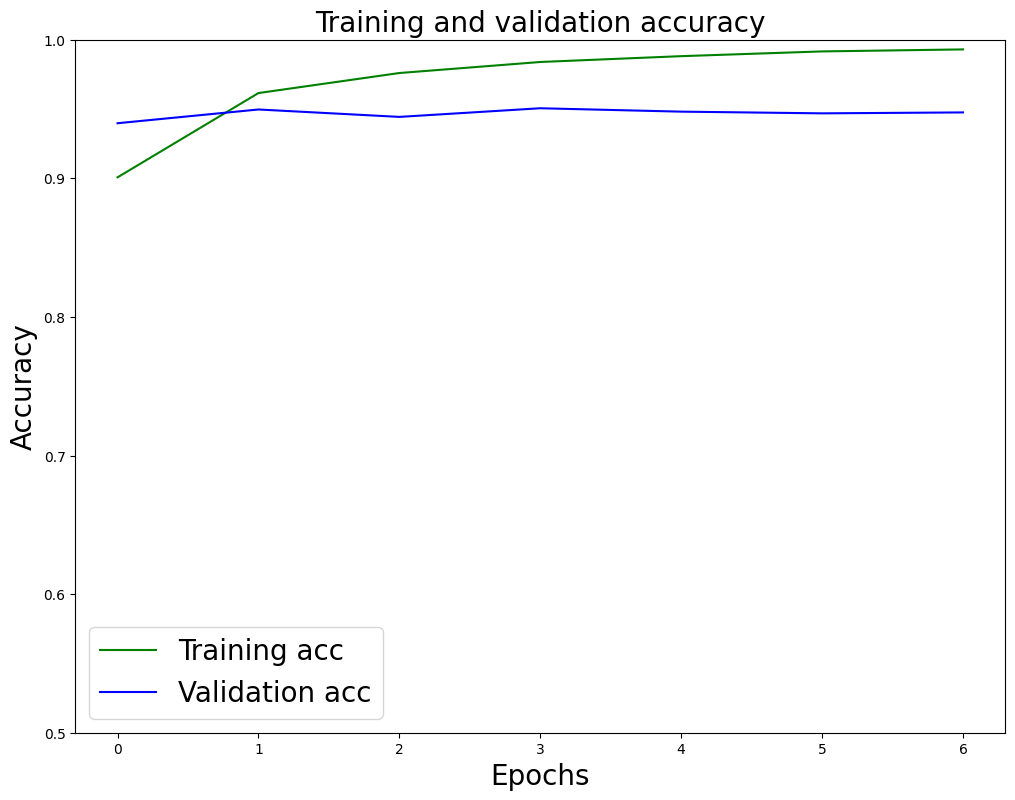

In [15]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()


In [16]:
df_whole = df.loc[:,["complete","target"]]
df_whole.head()

,complete,target
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


In [17]:
df_whole['clean_text'] = df['complete'].apply(preprocess)
df_whole['clean_text'][0]

['budget',
 'fight',
 'looms',
 'republicans',
 'flip',
 'fiscal',
 'script',
 'washington',
 'reuters',
 'head',
 'conservative',
 'republican',
 'faction',
 'congress',
 'voted',
 'month',
 'huge',
 'expansion',
 'national',
 'debt',
 'pay',
 'tax',
 'cuts',
 'called',
 'fiscal',
 'conservative',
 'sunday',
 'urged',
 'budget',
 'restraint',
 'keeping',
 'sharp',
 'pivot',
 'way',
 'republicans',
 'representative',
 'mark',
 'meadows',
 'speaking',
 'cbs',
 'face',
 'nation',
 'drew',
 'hard',
 'line',
 'federal',
 'spending',
 'lawmakers',
 'bracing',
 'battle',
 'january',
 'return',
 'holidays',
 'wednesday',
 'lawmakers',
 'begin',
 'trying',
 'pass',
 'federal',
 'budget',
 'fight',
 'likely',
 'linked',
 'issues',
 'immigration',
 'policy',
 'november',
 'congressional',
 'election',
 'campaigns',
 'approach',
 'republicans',
 'seek',
 'control',
 'congress',
 'president',
 'donald',
 'trump',
 'republicans',
 'want',
 'big',
 'budget',
 'increase',
 'military',
 'spending',
 '

In [18]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df_whole['complete'])
x_tokenized = tokenizer.texts_to_sequences(df_whole['complete'])

In [19]:
x = df_whole["complete"]
y = df_whole["target"]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=18)

In [21]:
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

In [22]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

In [23]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [24]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 128)         49664     
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 32)                18560     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [26]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1078/1078 [==============================] - 386s 341ms/step - loss: 0.1729 - accuracy: 0.9255 - val_loss: 0.0772 - val_accuracy: 0.9713
Epoch 2/10
1078/1078 [==============================] - 358s 332ms/step - loss: 0.0581 - accuracy: 0.9805 - val_loss: 0.1529 - val_accuracy: 0.9182
Epoch 3/10
1078/1078 [==============================] - 446s 414ms/step - loss: 0.0528 - accuracy: 0.9833 - val_loss: 0.0562 - val_accuracy: 0.9852
Epoch 4/10
1078/1078 [==============================] - 308s 285ms/step - loss: 0.0251 - accuracy: 0.9913 - val_loss: 0.0395 - val_accuracy: 0.9886
Epoch 5/10
1078/1078 [==============================] - 306s 284ms/step - loss: 0.0082 - accuracy: 0.9975 - val_loss: 0.0370 - val_accuracy: 0.9916
Epoch 6/10
1078/1078 [==============================] - 305s 282ms/step - loss: 0.0096 - accuracy: 0.9972 - val_loss: 0.0588 - val_accuracy: 0.9866
Epoch 7/10
1078/1078 [==============================] - 306s 284ms/step - loss: 0.0067 - accuracy: 0.9978 - val_

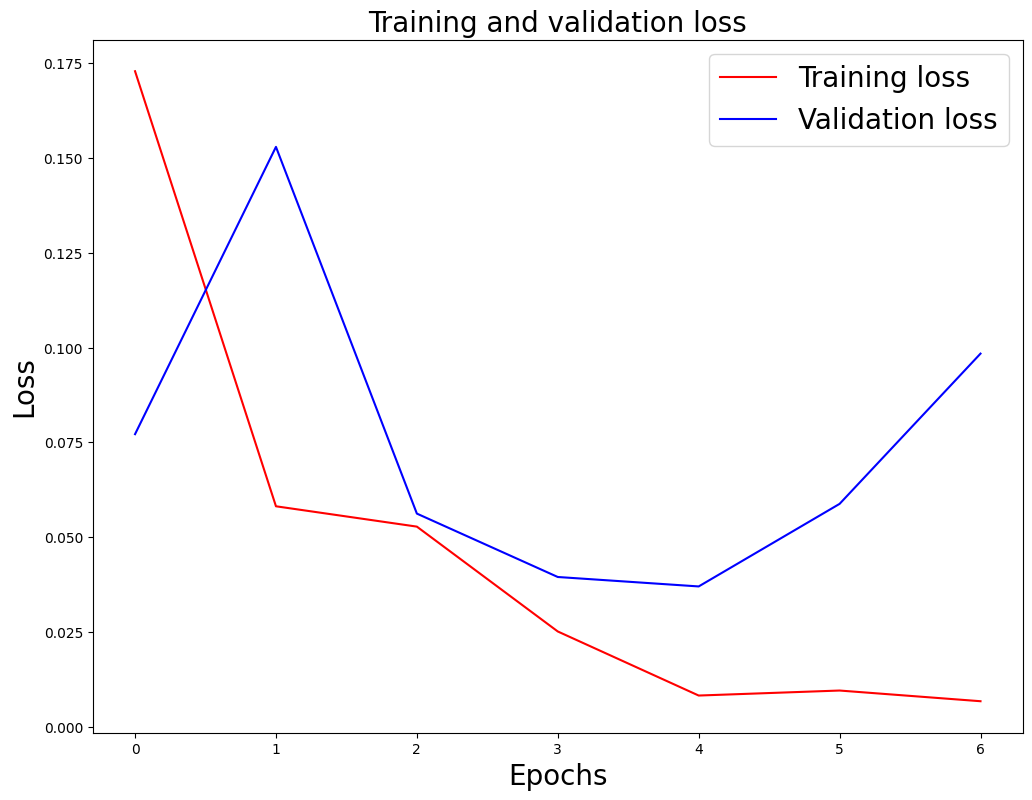

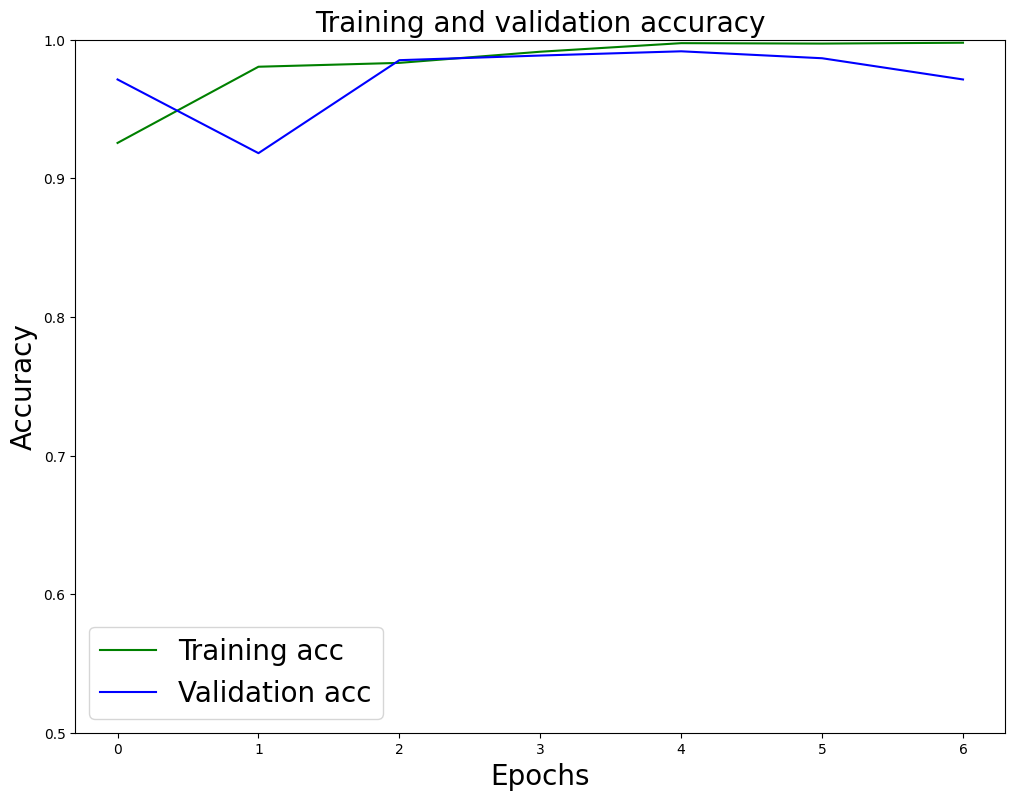

In [27]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

In [28]:
model.evaluate(X_test, y_test)

281/281 [==============================] - 22s 79ms/step - loss: 0.0523 - accuracy: 0.9869


[0.052304383367300034, 0.9868596792221069]

In [29]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

281/281 [==============================] - 68s 84ms/step


In [30]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9868596881959911
Precision on testing set: 0.9828558008454673
Recall on testing set: 0.9893617021276596


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

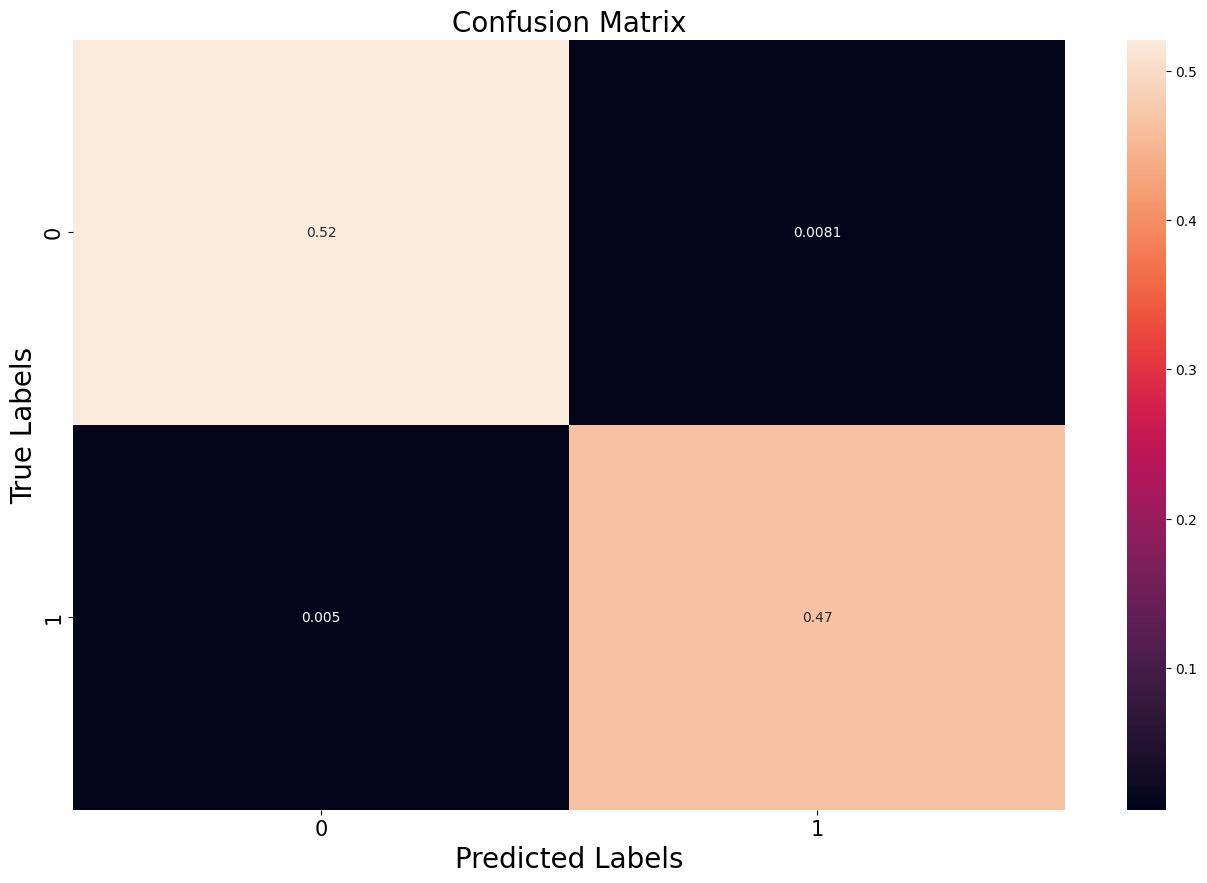

In [31]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

In [32]:
length_array = [len(s) for s in X_train]
SEQUENCE_LENGTH = int(np.quantile(length_array,0.75))
print(SEQUENCE_LENGTH)

256


In [33]:
VOCAB_LENGTH = len(tokenizer.word_index) + 1
VECTOR_SIZE = 100

def getModel():
    """
    Returns a trainable Sigmoid Convolutional Neural Network
    """
    model = keras.Sequential()
    model.add(layers.Embedding(input_dim= VOCAB_LENGTH, output_dim=VECTOR_SIZE, input_length=SEQUENCE_LENGTH))
    
    model.add(layers.Conv1D(128,kernel_size=4))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.MaxPooling1D(2))
    
    model.add(layers.Conv1D(256,kernel_size=4))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(256,kernel_size=4))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.MaxPooling1D(2))
    
    model.add(layers.Conv1D(512,kernel_size=4))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.MaxPooling1D(2))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1,activation="sigmoid"))
    
    model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
    
    return model

In [34]:
model = getModel()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 256, 100)          10807400  
                                                                 
 conv1d_1 (Conv1D)           (None, 253, 128)          51328     
                                                                 
 batch_normalization (Batch  (None, 253, 128)          512       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 253, 128)          0         
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 126, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 123, 256)         

In [35]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=1)

1123/1123 [==============================] - 443s 391ms/step - loss: 0.1298 - accuracy: 0.9529 - val_loss: 0.0574 - val_accuracy: 0.9807


In [36]:
model.save_weights("trained_model.h5")
import pickle
with open("tokenizer.pickle",mode="wb") as F:
    pickle.dump(tokenizer,F)
import json
label_map = {0:"Fake",
             1:"Real"
            }

json.dump(label_map,open("label_map.json",mode="w"))

In [37]:
def cleanText(text):
    cleaned = re.sub("[^'a-zA-Z0-9]"," ",text)
    lowered = cleaned.lower().strip()
    return lowered
x_cleaned = [cleanText(t) for t in x]

In [38]:
class DeployModel():
    
    def __init__(self,weights_path,tokenizer_path,seq_length,label_map_path
                ):
        
        self.model = getModel()
        self.model.load_weights(weights_path)
        self.tokenizer = pickle.load(open(tokenizer_path,mode="rb"))
        self.seq_len = seq_length
        self.label_map = json.load(open(label_map_path))
    
    def _prepare_data(self,text):
        
        cleaned = cleanText(text)
        tokenized = self.tokenizer.texts_to_sequences([cleaned])
        padded = pad_sequences(tokenized,maxlen=self.seq_len)
        return padded
    
    def _predict(self,text):
        
        text = self._prepare_data(text)
        #pred = int(self.model.predict_classes(text)[0])
        pred_probabilities = self.model.predict(text)
        pred_class = int(tf.argmax(pred_probabilities, axis=1)[0])
        return str(pred_class)
    
    def result(self,text):
        
        pred = self._predict(text)
        return self.label_map[pred]

In [39]:
deploy_model = DeployModel(weights_path="./trained_model.h5",
                           tokenizer_path="./tokenizer.pickle",
                           seq_length=SEQUENCE_LENGTH,
                           label_map_path="./label_map.json"
                          )



In [40]:
test_text_real = x_cleaned[1010]
print(test_text_real)
print("Results: ",deploy_model.result(test_text_real))

senators from refinery states request trump meeting on biofuels  reuters    nine u s  senators from states that have oil refineries sent a letter to president donald trump on thursday urging changes to the country s biofuels policy and asking for a meeting to discuss the issue  the letter reflects growing tensions between refiners that oppose the u s  renewable fuel standard   a law requiring them to blend increasing amounts of ethanol into the nation s fuel each year   and the midwest corn lobby that supports it  the trump administration bowed to rising pressure from midwest lawmakers last week  assuring them in letters and phone calls that it would ditch proposals  supported by the refining industry  to overhaul the biofuels policy  the senators said that decision could cost jobs   if your administration does not make adjustments or reforms on matters related to the renewable fuel standard  it will result in a loss of jobs around the country  particularly in our states   according to

In [41]:
test_text_fake = x_cleaned[30000]
print(test_text_fake)
print("\n\n===========================")
print("Results: ",deploy_model.result(test_text_fake))

kevin spacey predicts what would happen if frank underwood ever debated trump  video  house of cards star kevin spacey  who plays the fictional character president frank underwood  sat down with cnbc international on thursday and just couldn t avoid getting asked questions concerning the 2016 presidential election  chief among them was a question about what would happen if donald trump ever had to debate frank underwood here is the answer he gave  which drew quite a bit of laughter  he wouldn t  debate underwood   there would be a terrible accident  on the way to the debate  it would be terrible  and very sad  if that wasn t funny enough  he followed that up with his best trump impersonation  i m huuuge  i m too huge for this church  spacey is currently making rounds across the globe promoting the new upcoming season of house of cards  which airs in march  he was also asked this very same question at the annual skybridge capital reception hosted at a piano bar just a day earlier  he sa